In [ ]:
!pip install yfinance

In [34]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from plotly import graph_objs as go

In [35]:
df = yf.download(tickers='AAPL', period='3y')

[*********************100%***********************]  1 of 1 completed


In [36]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-10,78.544998,80.387497,78.462502,80.387497,78.940720,109348800
2020-02-11,80.900002,80.974998,79.677498,79.902496,78.464455,94323200
2020-02-12,80.367500,81.805000,80.367500,81.800003,80.327827,113730400
2020-02-13,81.047501,81.555000,80.837502,81.217499,79.755798,94747600
2020-02-14,81.184998,81.495003,80.712502,81.237503,79.775429,80113600
...,...,...,...,...,...,...
2023-02-02,148.899994,151.179993,148.169998,150.820007,150.820007,118339000
2023-02-03,148.029999,157.380005,147.830002,154.500000,154.500000,154279900
2023-02-06,152.570007,153.100006,150.779999,151.729996,151.729996,69858300


In [37]:
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [39]:
n_lookback = 60 
n_prediction = 15

X = []
Y = []

for i in range(n_lookback, len(y) - n_prediction + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_prediction])

X = np.array(X)
Y = np.array(Y)

In [40]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_prediction))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 15)                765       
                                                                 
Total params: 31,365
Trainable params: 31,365
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
22/22 [==============================] - 6s 95ms/step - loss: 0.2127
Epoch 2/10
22/22 [==============================] - 2s 97ms/step - loss: 0.0190
Epoch 3/10
22/22 [==============================] - 2s 69ms/step - loss: 0.0081
Epoch 4/10
22/22 [==============================] - 2s 70ms/step - loss: 0.0061
Epoch 5/10
22/22 [==============================] - 2s 71ms/step - loss: 0.0063
Epoch 6/10
22/22 [==============================] - 2s 72ms/step - loss: 0.0058
Epoch 7/10
22/22 [==============================] - 2s 70ms/step - loss: 0.0054
Epoch 8/10
22/22 [==============================] - 2s 71ms/step - loss: 0.0057
Epoch 9/10
22/22 [==============================] - 2s 100ms/step - loss: 0.0052
Epoch 10/10
22/22 [==============================] - 2s 93ms/step - loss: 0.0049


In [42]:
X_pred = y[- n_lookback:]
X_pred = X_pred.reshape(1, n_lookback, 1)
Y_pred = model.predict(X_pred).reshape(-1, 1)
Y_pred = scaler.inverse_transform(Y_pred)

1/1 [==============================] - 1s 865ms/step


In [43]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Prediction'] = np.nan
df_past['Prediction'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Prediction'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_prediction)
df_future['Prediction'] = Y_pred.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 771 entries, 2020-02-10 to 2023-02-23
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Actual      756 non-null    float64
 1   Prediction  16 non-null     float64
dtypes: float64(2)
memory usage: 18.1 KB


In [45]:
results

,Actual,Prediction
Date,,
2020-02-10,80.387497,NaN
2020-02-11,79.902496,NaN
2020-02-12,81.800003,NaN
2020-02-13,81.217499,NaN
2020-02-14,81.237503,NaN
...,...,...
2023-02-19,NaN,143.268127
2023-02-20,NaN,142.345718
2023-02-21,NaN,143.793930


<Figure size 1800x504 with 0 Axes>

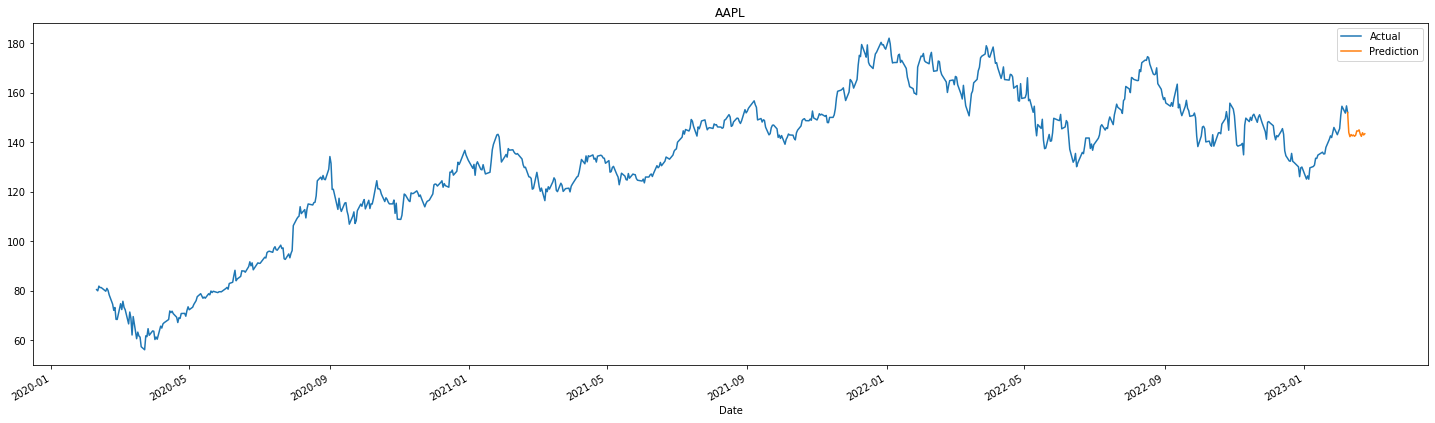

In [46]:
plt.figure(figsize=(25,7))
results.plot(title='AAPL',figsize=(25,7))

In [47]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=results.index, y=results['Actual'], name="Actual Stock Price"))
fig.add_trace(go.Scatter(x=results.index, y=results['Prediction'], name="Predicted Stock Price",line=dict(color='red', width=4)))
fig.layout.update(title_text='15 days Stock Price Prediction with Rangeslider', xaxis_rangeslider_visible=True)
fig.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
fig.show()

In [48]:
ma10 = df.Close.rolling(10).mean()
ma50 = df.Close.rolling(50).mean()
ma100 = df.Close.rolling(100).mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name="Actual Stock Price"))
fig.add_trace(go.Scatter(x=ma10.index, y=ma10, name="10 Moving Avg",line=dict(color='red')))
fig.add_trace(go.Scatter(x=ma50.index, y=ma50, name="50 Moving Avg",line=dict(color='yellow')))
fig.add_trace(go.Scatter(x=ma100.index, y=ma100, name="100 Moving Avg",line=dict(color='green')))
fig.layout.update(title_text='Moving Average Stock Price data', xaxis_rangeslider_visible=True)
fig.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
fig.show()